# Flamant's problem (analytical and numerical solution)

© 2022 Exneyder A. Montoya-Araque, Daniel F. Ruiz and Universidad EAFIT.

This notebook can be interactively run in [Google - Colab](https://colab.research.google.com/github/AppliedMechanics-EAFIT/foundation_eng/blob/main/notebooks/flamants_line_load.ipynb).

> Note: Be aware that this notebook follows solid mechanics sign conventions → Tractions are positive, compressions are negative, and shear forces/stresses are positive when they act on the positive $x$-plane and point to the positive $y$-direction.

This notebook depends on:
* SolidsPy V1.0.16 [Guarín-Zapata et al. (2020)](https://doi.org/10.5281/zenodo.4029270)
* pygmsh V6.0.2 [Schlömer et al. (2019a)](https://doi.org/10.5281/zenodo.3541027)
* meshio V3.3.1 [Schlömer et al. (2019b)](https://doi.org/10.5281/zenodo.3584511)
* And other packages for general scientific programming in Python


## Setting up the environment

### Required modules and setup for plots

In [34]:
from IPython import get_ipython
if 'google.colab' in str(get_ipython()):
    from google.colab import output
    output.enable_custom_widget_manager()
    print('Running on CoLab. Installing the required modules...')
    %pip install gmsh==4.10.5 &> ~/pip-log.txt
    %pip install meshio==3.3.1 &> ~/pip-log.txt
    %pip install pygmsh==6.0.2 &> ~/pip-log.txt
    %pip install solidspy==1.0.16 &> ~/pip-log.txt
    # %pip install numpy==1.23.1 &> ~/pip-log.txt
    %pip install ipympl &> ~/pip-log.txt &> ~/pip-log.txt

import pygmsh
import meshio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import MaxNLocator
import solidspy.preprocesor as pre
import solidspy.postprocesor as pos
import solidspy.assemutil as ass
import solidspy.solutil as sol
from ipywidgets import interact, widgets, FloatSlider, FloatText, fixed
from IPython.display import display, clear_output

%matplotlib widget

plt.style.use("default")
mpl.rcParams.update(
    {
        'figure.constrained_layout.use': True,
        'interactive': False,
        "text.usetex": False,  # Use mathtext, not LaTeX
        "font.family": "cmr10",  # Use the Computer modern font
        "mathtext.fontset": "cm",
        "axes.formatter.use_mathtext": True,
        "axes.unicode_minus": False,
    }
)

In [35]:
%%html
<style> div.jupyter-widgets.widget-label {display: none;} </style>

## Functions

### FEM solution

#### Creating the domain and meshing it

In [36]:
def create_domain(x_load=0, y_load=0, l=20, z=10, elem_size=2.0):
    '''Parameters in the International System of Units.
    - Lengths in [m]
    '''
    # Empty structure
    geom = pygmsh.built_in.Geometry()
    # Points
    p1 = geom.add_point([x_load + 0.0, y_load + 0.0, 0.0], elem_size/10)
    p2 = geom.add_point([x_load - l / 2, y_load + 0.0, 0.0], elem_size)
    p3 = geom.add_point([x_load - l / 2, y_load - z, 0.0], elem_size)
    p4 = geom.add_point([x_load - 0 / 2, y_load - z, 0.0], elem_size/3)
    p5 = geom.add_point([x_load + l / 2, y_load - z, 0.0], elem_size)
    p6 = geom.add_point([x_load + l / 2, y_load + 0, 0.0], elem_size)
    # Lines
    l1 = geom.add_line(p1, p2)  # Upper line 1
    l2 = geom.add_line(p2, p3)  # Rigth line
    l3 = geom.add_line(p3, p4)  # Bottom line 1
    l4 = geom.add_line(p4, p5)  # Bottom line 2
    l5 = geom.add_line(p5, p6)  # Left line
    l6 = geom.add_line(p6, p1)  # Upper line 2
    l7 = geom.add_line(p4, p1)  # Vertical line at lodad position
    # Surfaces
    ll1 = geom.add_line_loop([l1, l2, l3, l7])
    s1 = geom.add_plane_surface(ll1)
    ll2 = geom.add_line_loop([-l7, l4, l5, l6])
    s2 = geom.add_plane_surface(ll2)
    # Physical groups
    geom.add_physical(s1, label="100")  # Material
    geom.add_physical(s2, label="110")  # Material
    geom.add_physical(p1, label="200")  # Point load
    geom.add_physical([l2, l5], label="300")  # Lateral boundary
    geom.add_physical([l3, l4], label="400")  # Lower boundary
    geom.add_physical([l6, l1], label="500")  # Upper boundary
    geom.add_physical(l7, label="500")  # Vertical line at lodad position
    return pygmsh.generate_mesh(
        geom, geo_filename="mesh.geo", msh_filename="mesh.msh"
    )

def plot_mesh(nodes, elements, loads, **kwargs):
    tri_mesh = pos.mesh2tri(nodes, elements)
    figsize = kwargs.get('figsize', [8, 5])
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=figsize)
    load = nodes[int(loads[0, 0])]
    ax.triplot(tri_mesh, marker=".", lw=0.5, ms=2, color="tomato")
    ax.arrow(x=load[1], y=load[2]+1, dx=0, dy=-1, width=.05,  fc='k', ec='k',
              length_includes_head=True)
    ax.axis("image")
    ax.set(xlabel='$x$  [m]', ylabel='$y$  [m]')
    # fig.tight_layout()
    plt.show()
    return

def mesh2tri(nodes, elements, field):
    coord_x = nodes[:, 1]
    coord_y = nodes[:, 2]
    triangs = [elem[3:] for elem in elements]
    mask = np.any(np.isinf(field[triangs]), axis=1)
    mask += np.any(np.isnan(field[triangs]), axis=1)
    tri = mpl.tri.Triangulation(coord_x, coord_y, np.array(triangs), mask)
    return tri

def plot_fields(
        fields, nodes, elements, titles, share_colorbar=True, cmap="RdYlBu",
         plot_eigenvalues=False, **kwargs):
    fig, axs = plt.subplots(
        ncols=len(fields), nrows=1, figsize=[4.2*len(fields), 4], sharey=True)
    if len(fields) == 1:
        axs = list(axs)
    levels = 16
    if share_colorbar:
        vmin = min(np.nanmin(field[np.isfinite(field)]) for field in fields)
        vmax = max(np.nanmax(field[np.isfinite(field)]) for field in fields)
        locator = MaxNLocator(nbins=levels, prune='both')
        levels = locator.tick_values(vmin, vmax)
    else: 
        vmin, vmax = None, None
    for ax, field, title, i in zip(axs, fields, titles, range(len(fields))):
        tri_mesh = mesh2tri(nodes, elements, field)
        im = ax.tricontourf(
            tri_mesh, field, levels=levels, vmin=vmin, vmax=vmax,
            cmap=cmap, extend='both')
        ax.axis('image')
        ax.set_title(title)
        ax.set_xlabel('$x$  [m]')
        if plot_eigenvalues:
            plot_eigenval(kwargs['complete_tensors'][i], nodes, elements, ax)
        if not share_colorbar:
            fig.colorbar(im, ax=ax, shrink=.7, pad=0.01)
    axs[0].set_ylabel('$y$  [m]')
    if share_colorbar:
        fig.colorbar(im, ax=axs, shrink=.7, pad=0.01)
    plt.show()
    return

def plot_eigenval(tensors, nodes, elements, ax):
    # Create the grid
    xx = np.linspace(nodes[:, 1].min(), nodes[:, 1].max(), 50)
    yy = np.linspace(nodes[:, 2].min(), nodes[:, 2].max(), 50)
    x_grid, y_grid = np.meshgrid(xx, yy)
    x_grid, y_grid
    # Interpolate values at regular grid and flatten them
    sigma_x = get_a_value(x_grid, y_grid, tensors["𝜎_xx"], nodes, elements).flatten()
    sigma_y = get_a_value(x_grid, y_grid, tensors["𝜎_yy"], nodes, elements).flatten()
    tau_xy = get_a_value(x_grid, y_grid, tensors["𝜏_xy"], nodes, elements).flatten()
    # Obtain principal directions from tensors, rearrange them properly
    sigma_1, sigma_3, eigvec_1, eigvec_3 = pos.principal_dirs(
            np.array([sigma_x, sigma_y, tau_xy]).T)
    sigma_1 = sigma_1.reshape(-1, len(xx))
    sigma_3 = sigma_3.reshape(-1, len(xx))
    eigvec_1_x = eigvec_1[:, 0].reshape(-1, len(xx))
    eigvec_1_y = eigvec_1[:, 1].reshape(-1, len(xx))
    eigvec_3_x = eigvec_3[:, 0].reshape(-1, len(xx))
    eigvec_3_y = eigvec_3[:, 1].reshape(-1, len(xx))
    # Update axix
    ax.streamplot(x=xx, y=yy, u=eigvec_1_x, v=eigvec_1_y, color='k', linewidth=0.2, arrowstyle='-')
    ax.streamplot(x=xx, y=yy, u=eigvec_3_x, v=eigvec_3_y, color='k',  linewidth=0.2, arrowstyle='-')

def get_a_value(x, y, field, nodes, elements, ):
    '''Parameters in the International System of Units.
    - Lengths in [m]
    - Stress in [kPa]
    '''
    tri_mesh = pos.mesh2tri(nodes, elements)  # Triangular mesh structure
    interpolator = mpl.tri.CubicTriInterpolator(tri_mesh, z=field, kind='geom')
    return np.float64(interpolator(x, y).data)

#### Creating solidspy inputs

In [37]:
def solidspy_inputs(mesh, elastic_mod, poisson_rat, load_x, load_y):
    """Parameters in the International System of Units.
    - Lengths in [m]
    - Loads (forces) in [N/m]
    """
    points = mesh.points
    cells = mesh.cells
    point_data = mesh.point_data
    cell_data = mesh.cell_data
    field_data = mesh.field_data
    # Element data
    eles = cells["triangle"]
    els_array = np.zeros([eles.shape[0], 6], dtype=int)
    els_array[:, 0] = range(eles.shape[0])
    els_array[:, 1] = 3
    els_array[:, 3::] = eles.data
    # Nodes
    nodes_array = np.zeros([points.shape[0], 5])
    nodes_array[:, 0] = range(points.shape[0])
    nodes_array[:, 1:3] = points[:, :2]
    # Loads
    id_cargas = cells["vertex"]
    loads_array = np.array([[id_cargas[0][0], load_x, load_y]])
    # Boundaries
    lines = cells["line"]
    bounds = cell_data["line"]["gmsh:physical"]
    nbounds = len(bounds)
    id_izq_der = [cont for cont in range(nbounds) if bounds[cont] == 3]
    id_inf = [cont for cont in range(nbounds) if bounds[cont] == 4]
    nodes_izq_der = lines[id_izq_der].flatten()
    nodes_inf = lines[id_inf].flatten()
    nodes_array[nodes_izq_der, 3] = -1
    nodes_array[nodes_inf, 3:] = (-1, -1)
    #  Material
    mats_array = np.array([[elastic_mod, poisson_rat]])
    return (nodes_array, mats_array, els_array, loads_array)


#### Executing the solver

In [38]:
def run_solidspy(nodes, mats, elements, loads):
    """Parameters in the International System of Units.
    - Lengths in [m]
    - Stress in [kPa]
    """
    # System assembly
    assem_op, bc_array, neq = ass.DME(nodes, elements)
    stiff_mat = ass.assembler(elements, mats, nodes, neq, assem_op)
    rhs_vec = ass.loadasem(loads, bc_array, neq)
    # System solution
    disp = sol.static_sol(stiff_mat, rhs_vec)
    # Post-processing
    # Fill the displacement vectors with imposed and computed values
    disp = pos.complete_disp(bc_array, nodes, disp)
    # Averaged strains and stresses at nodes
    strain, stress = pos.strain_nodes(nodes, elements, mats, disp)
    # Compute the principal directions of a tensor field
    eigs1, eigs3, eigvec_1, eigvec_3 = pos.principal_dirs(stress)
    tensors = {
        "𝜎_1": 1e-3 * eigs1,
        "𝜎_2": np.full_like(eigs1, np.nan),
        "𝜎_3": 1e-3 * eigs3,
        "𝜎_xx": 1e-3 * stress[:, 0],
        "𝜎_yy": 1e-3 * stress[:, 1],
        "𝜏_xy": 1e-3 * stress[:, 2],
        "𝜀_xx": strain[:, 0],
        "𝜀_yy": strain[:, 1],
        "𝛾_xy": strain[:, 2],
        "𝑢_x": disp[:, 0],
        "𝑢_y": disp[:, 1],
    }
    return tensors, eigvec_1, eigvec_3


## Analytical solution

In [39]:
def flamant(x, y, d=50, elastic_mod=50e6, poisson_rat=0.3, load_y=-1e9):
    """Parameters in the International System of Units.
    - Lengths in [m]
    - Loads (forces) in [N/m]
    - Stress in [kPa]
    """
    np.seterr(divide="ignore", invalid="ignore")
    load_y = -1 * load_y
    r = np.sqrt(x**2 + y**2)
    sigma_x = 1e-3 * (2 * load_y * x**2 * y) / (np.pi * r**4)
    sigma_y = 1e-3 * (2 * load_y * y**3) / (np.pi * r**4)
    sigma_z = 1e-3 * (2 * load_y * poisson_rat * y) / (np.pi * r**2)
    tau_xy = 1e-3 * (2 * load_y * x * y**2) / (np.pi * r**4)
    sigma_1 = 1e-3 * (2 * load_y * y) / (np.pi * r**2)
    sigma_2 = 0 * sigma_x
    sigma_3 = sigma_z
    # Principal directions
    eigs1, eigs3, eigvec_1, eigvec_3 = pos.principal_dirs(
        np.array([sigma_x, sigma_y, tau_xy]).T
    )
    # Displacements
    sign = np.zeros_like(x)
    sign[np.where(x > 0)] = 1
    sign[np.where(x < 0)] = -1
    disp_x = sign * (
        0.5 * load_y * (1 + poisson_rat) * (1 - 2 * poisson_rat) / elastic_mod
    )
    disp_y = (
        2
        * load_y
        * (1 - poisson_rat**2)
        * np.log(d / np.abs(x))
        / elastic_mod
    )
    tensors = {
        "𝜎_1": sigma_1,
        "𝜎_2": sigma_2,
        "𝜎_3": sigma_3,
        "𝜎_xx": sigma_x,
        "𝜎_yy": sigma_y,
        "𝜏_xy": tau_xy,
        "𝜀_xx": np.full_like(sigma_1, np.nan),
        "𝜀_yy": np.full_like(sigma_1, np.nan),
        "𝛾_xy": np.full_like(sigma_1, np.nan),
        "𝑢_x": disp_x,
        "𝑢_y": disp_y,
    }
    return tensors, eigvec_1, eigvec_3


## Comparing solutions

In [40]:
def compare_solutions(x, y, field, tensors_FEM, tensors_AS, nodes, elements):
    '''Parameters in the International System of Units.
    - Lengths (and coordinates) in [m]
    - Loads (forces) in [N/m]
    - Stress in [kPa]
    '''
    units = 'kPa'
    if field in ['𝑢_x', '𝑢_y']:
        units = 'm'
    elif field in ['𝜀_xx', '𝜀_yy', '𝛾_xy']:
        units = ''

    field_at_xy_FEM = get_a_value(x, y, tensors_FEM[field], nodes, elements)
    if np.isnan(field_at_xy_FEM):
        print(f'{field} at ({x}, {y}) by FEM is indeterminate/unknown')
    else:
        print(f'{field} at ({x}, {y}) by FEM is {float(field_at_xy_FEM):.2f} {units}')

    field_at_xy_AS = get_a_value(x, y, tensors_AS[field], nodes, elements)
    if np.isnan(field_at_xy_AS):
        print(f'{field} at ({x}, {y}) by analytical solution is indeterminate/unknown')
    else:
        print(f'{field} at ({x}, {y}) by analytical solution is {float(field_at_xy_AS):.2f} {units}')
    return


## Running a case

In [41]:
# GLOBAL INPUTS
load = -1e7  # [N/m]
elastic_mod = 50e6  # [N/m²]
poisson_rat = 0.3
domain_width = 20  # [m]
domain_depth = 20  # [m]
d = 10  # [m] Depth of inmovile point below load for analytical solution of displacements

# FEM SOLUTION
# Creating the domain and meshing it
mesh = create_domain(x_load=0, y_load=0, l=domain_width, z=domain_depth, elem_size=2)
# Creating solidspy inputs
nodes, mats, elements, loads = solidspy_inputs(mesh, elastic_mod, poisson_rat, load_x=0, load_y=load)
tensors_FEM, eigvec_1_FEM, eigvec_3_FEM = run_solidspy(nodes, mats, elements, loads)

# ANALYTICAL SOLUTION
# Coordinates at nodes
x, y = nodes[:, 1:3].T
# Executing the analytical solver
# np.seterr(divide='ignore')
tensors_AS, eigvec_1_AS, eigvec_3_AS = flamant(x, y, d, elastic_mod, poisson_rat, load)

Info    : Running '/home/eamontoyaa/.pyenv/versions/3.9.13/envs/solidspy-env/bin/gmsh -3 mesh.geo -format msh -bin -o mesh.msh' [Gmsh 4.10.5, 1 node, max. 1 thread]
Info    : Started on Tue Apr  4 15:40:21 2023
Info    : Reading 'mesh.geo'...
Error   : Physical curve 6 already exists
Error   : 'mesh.geo', line 41: Could not modify physical line
Info    : Done reading 'mesh.geo'
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 20%] Meshing curve 2 (Line)
Info    : [ 30%] Meshing curve 3 (Line)
Info    : [ 50%] Meshing curve 4 (Line)
Info    : [ 60%] Meshing curve 5 (Line)
Info    : [ 80%] Meshing curve 6 (Line)
Info    : [ 90%] Meshing curve 7 (Line)
Info    : Done meshing 1D (Wall 0.00588708s, CPU 0.002879s)
Info    : Meshing 2D...
Info    : [  0%] Meshing surface 9 (Plane, Frontal-Delaunay)
Info    : [ 50%] Meshing surface 11 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.013932s, CPU 0.013926s)
Info    : Meshing 3D...
Info    : Done meshing 3D 

## Plotting results

### Mesh

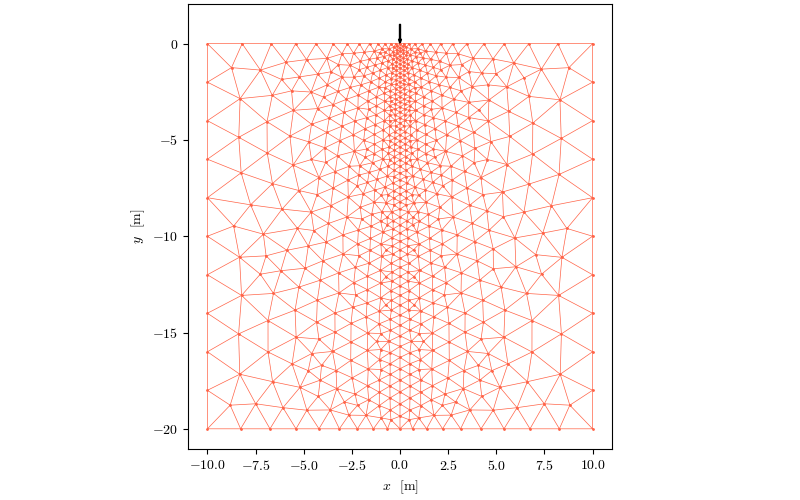

In [42]:
plot_mesh(nodes, elements, loads)

### Cartesian stresses

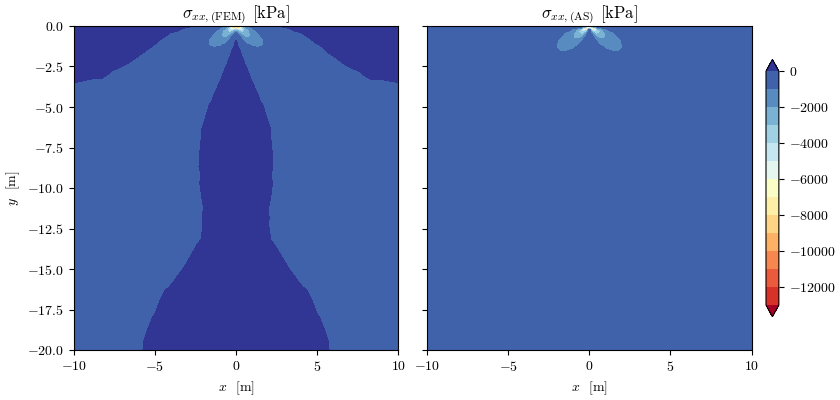

In [43]:
plot_fields(  # Stresses in xx-direction
    fields=(tensors_FEM["𝜎_xx"], tensors_AS["𝜎_xx"]),
    nodes=nodes, elements=elements,
    titles=["$\sigma_{xx, \mathrm{(FEM)}}$ [kPa]", "$\sigma_{xx, \mathrm{(AS)}}$ [kPa]"],
    share_colorbar=True
)

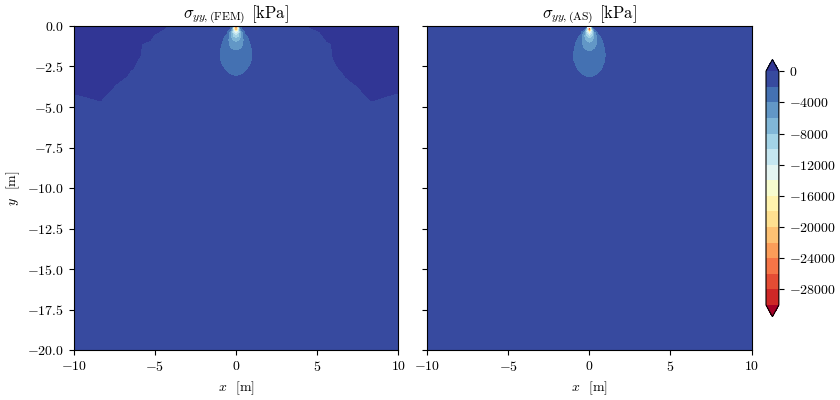

In [44]:
plot_fields(  # Stresses in yy-direction
    fields=(tensors_FEM["𝜎_yy"], tensors_AS["𝜎_yy"]),
    nodes=nodes, elements=elements,
    titles=["$\sigma_{yy, \mathrm{(FEM)}}$ [kPa]", "$\sigma_{yy, \mathrm{(AS)}}$ [kPa]"],
    share_colorbar=True
)

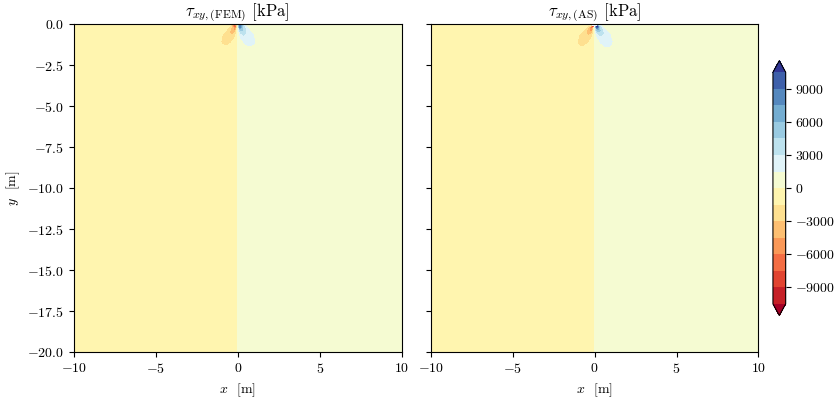

In [45]:
plot_fields(  # Stresses in xy-direction
    fields=(tensors_FEM["𝜏_xy"], tensors_AS["𝜏_xy"]),
    nodes=nodes, elements=elements,
    titles=["$\\tau_{xy, \mathrm{(FEM)}}$ [kPa]", "$\\tau_{xy, \mathrm{(AS)}}$ [kPa]"],
    share_colorbar=True
)


### Principal stresses and directions

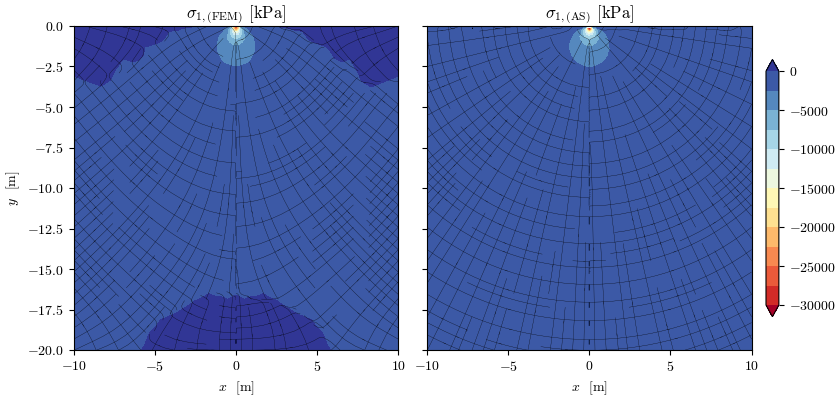

In [46]:
# Major principal stress
fig = plot_fields(
    fields=(tensors_FEM["𝜎_1"], tensors_AS["𝜎_1"]),
    nodes=nodes, elements=elements,
    titles=["$\sigma_{1, \mathrm{(FEM)}}$ [kPa]", "$\sigma_{1, \mathrm{(AS)}}$ [kPa]"],
    share_colorbar=True,
    plot_eigenvalues=True,
    complete_tensors=(tensors_FEM, tensors_AS)
)

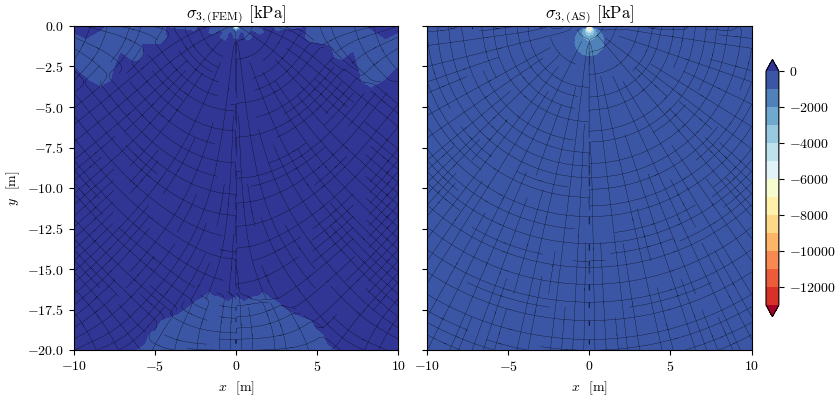

In [47]:
# Minor principal stress
fig = plot_fields(
    fields=(tensors_FEM["𝜎_3"], tensors_AS["𝜎_3"]),
    nodes=nodes, elements=elements,
    titles=["$\sigma_{3, \mathrm{(FEM)}}$ [kPa]", "$\sigma_{3, \mathrm{(AS)}}$ [kPa]"],
    share_colorbar=True,
    plot_eigenvalues=True,
    complete_tensors=(tensors_FEM, tensors_AS)
)

### Displacements (FEM solution)

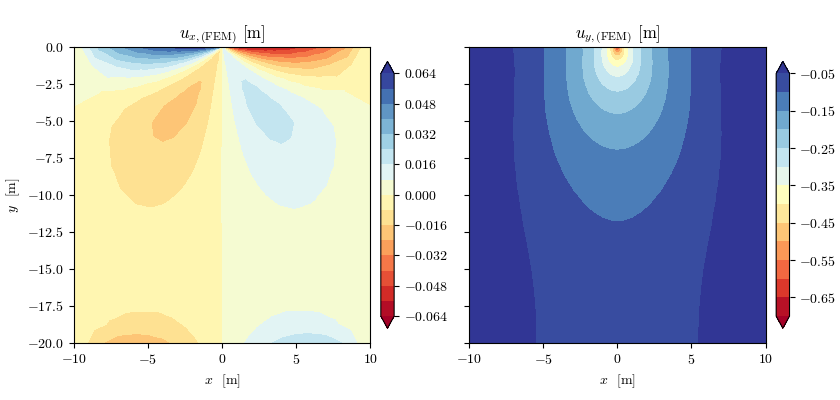

In [48]:
plot_fields(
    fields=(tensors_FEM["𝑢_x"], tensors_FEM["𝑢_y"]),
    nodes=nodes, elements=elements,
    titles=["$u_{x, \mathrm{(FEM)}}$ [m]", "$u_{y, \mathrm{(FEM)}}$ [m]"],
    share_colorbar=False
)

### Deformations  (FEM solution)

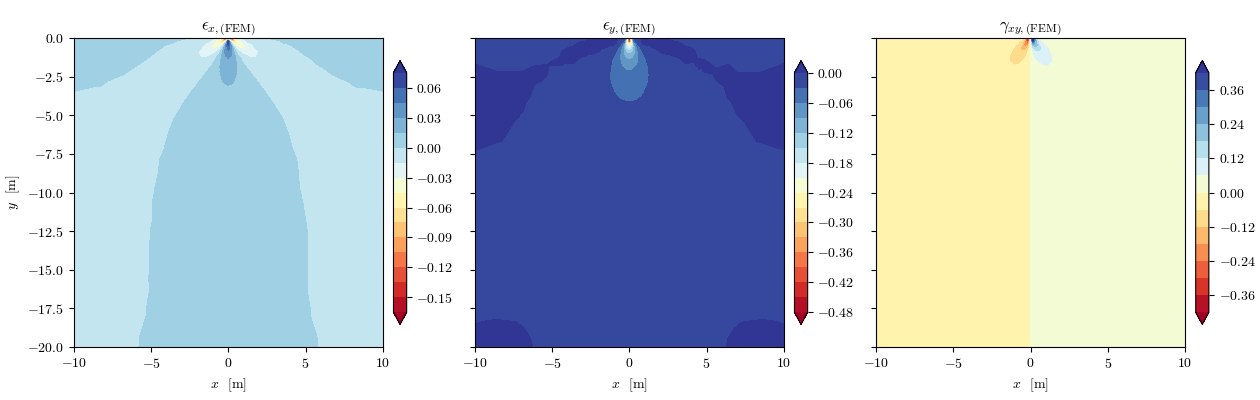

In [49]:
plot_fields(
    fields=(tensors_FEM["𝜀_xx"], tensors_FEM["𝜀_yy"], tensors_FEM["𝛾_xy"]),
    nodes=nodes, elements=elements,
    titles=["$\epsilon_{x, \mathrm{(FEM)}}$", "$\epsilon_{y, \mathrm{(FEM)}}$", "$\gamma_{xy, \mathrm{(FEM)}}$"],
    share_colorbar=False
)

## FEM vs Analytical solutions

In [50]:
interact(  # Interactive widgets
    compare_solutions,
    x = widgets.BoundedFloatText(value=0, min=nodes[:, 1].min(), max=nodes[:, 1].max(), step=0.5, description='x [m]:'),
    y = widgets.BoundedFloatText(value=-2, min=nodes[:, 2].min(), max=-.005, step=0.5, description='y [m]'),
    field = widgets.Dropdown(options=tensors_FEM.keys(), value='𝜎_yy', description='Field:'),
    tensors_FEM=fixed(tensors_FEM),
    tensors_AS=fixed(tensors_AS),
    nodes=fixed(nodes),
    elements=fixed(elements),
);

interactive(children=(BoundedFloatText(value=0.0, description='x [m]:', max=10.0, min=-10.0, step=0.5), Bounde…